<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات همان نکات مربوط به آموزش مدل برای Cifar2 با استفاده از alexnet است.
تنها تفاوت در این قسمت تمرین استفاده از triplet loss جهت آموزش یک featrue extractor خوب است.
<br>

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = dsets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform)

selected_classes = [0, 1]
train_filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in selected_classes]
test_filtered_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] in selected_classes]

subset_train_dataset = torch.utils.data.Subset(train_dataset, train_filtered_indices)
subset_test_dataset = torch.utils.data.Subset(test_dataset, test_filtered_indices)

print(len(subset_train_dataset))
print(len(subset_test_dataset))

100%|██████████| 170498071/170498071 [00:04<00:00, 42035526.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
10000
2000


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
این کلاس "TripletDataset" برای ساخت یک مجموعه داده از سه‌تایی‌ها (Triplet) بر اساس یک مجموعه دادهٔ پایه ایجاد شده است. هر سه‌تایی شامل سه نمونه از مجموعه داده است:

1. "Anchor": یک نمونه انتخاب شده به عنوان نقطهٔ مرجع.
2. "Positive": یک نمونه انتخاب شده از همان دستهٔ برچسبی که "Anchor" از آن انتخاب شده است.
3. "Negative": یک نمونه انتخاب شده از یک دستهٔ برچسبی متفاوت از "Anchor".

در واقعیت، این کلاس تصادفی یک نمونه "Anchor" را انتخاب کرده و سپس یک نمونه "Positive" از همان دستهٔ برچسبی که "Anchor" انتخاب شده است و یک نمونه "Negative" از یک دستهٔ برچسبی متفاوت انتخاب می‌کند. این عملیات به تناوب برای تمام نمونه‌های موجود در مجموعه داده اجرا می‌شود.
پ
<br>

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = np.array(self.base_dataset.dataset.targets)
        self.label_to_indices = {label: np.where(self.labels == label)[0] for label in self.labels}

    def __getitem__(self, index):
        target = np.random.choice(self.labels)
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[target])
        negative_target = np.random.choice(list(set(self.labels) - {target}))
        negative_index = np.random.choice(self.label_to_indices[negative_target])
        anchor = self.base_dataset.dataset[index][0]
        positive = self.base_dataset.dataset[positive_index][0]
        negative = self.base_dataset.dataset[negative_index][0]
        return anchor, positive, negative

    def __len__(self):
        return len(self.base_dataset)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print(device)

cuda


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت تابعی چهت ترین کردن مدل نوشته می شود.
روند تابع به شکل کلی به این صورت است که نتایج واقعی و حاصل از مدل مقایسه شده و با استفاده از تابع لاس موردنظر وزن ها به تدریج برحسب lr موردنظر آپدیت می شوند.
در انتها نتایج روی داده های تست نیز گزارش می شود.
<br>

In [ ]:
from tqdm import tqdm

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    val_acc = []
    train_acc = []
    accuracy_list = []
    loss_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_acc.append(val_accuracy)
        loss_list.append(average_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Test Accuracy: {val_accuracy:.4f}')

    return val_acc, train_acc, loss_list

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
   - مدل را بر روی دستگاه محاسباتی (مثل GPU) منتقل می‌کنیم.

   - حلقهٔ آموزش بر روی داده‌های آموزش اجرا می‌شود.
   - متغیر total_loss برای محاسبه میانگین از دست رفته در هر مرحله از آموزش استفاده می‌شود.
   - متغیرهای correct_train و total_train برای محاسبه دقت آموزش مدل به کار می‌روند.
   - برای هر سه‌تایی از داده‌های آموزش (anchor، positive و negative)، مدل embedding مربوط به هر یک از آن‌ها را محاسبه می‌کند.
   - سپس با استفاده از تابع pairwise_distance، فاصله میانگین میان "anchor" و "positive" و همچنین "anchor" و "negative" را محاسبه می‌کند.
   - مقدار تابع Triplet Loss برای هر سه‌تایی محاسبه شده و به عنوان اثر منفی بر روی مدل اعمال می‌شود.
   - پس از اتمام هر دوره از آموزش، اطلاعاتی مانند میانگین Triplet Loss و دقت آموزش در هر دوره نمایش داده می‌شود.
   - اطلاعات آموزش شامل میانگین Triplet Loss و دقت آموزش برای هر دوره در لیست loss_list و accuracy_list ذخیره می‌شوند.
<br>

In [ ]:
def train_triplet(model, train_loader, test_loader, criterion, optimizer, num_epochs=10 , margin = 0.2):
    model.to(device)

    accuracy_list = []
    loss_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for anchor, positive, negative in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - TripletTraining'):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()
            embed_anchor = model(anchor)
            embed_positive = model(positive)
            embed_negative = model(negative)
            # Flatten the embeddings before computing pairwise distance
            embed_anchor_flat = embed_anchor.view(embed_anchor.size(0), -1)
            embed_positive_flat = embed_positive.view(embed_positive.size(0), -1)
            embed_negative_flat = embed_negative.view(embed_negative.size(0), -1)

            # Compute pairwise distance


            # Calculate triplet loss
            loss_triplet = criterion(embed_anchor, embed_positive, embed_negative)

            loss_triplet.backward()
            optimizer.step()

            total_loss += loss_triplet.item()
            distance_positive = F.pairwise_distance(embed_anchor_flat, embed_positive_flat)
            distance_negative = F.pairwise_distance(embed_anchor_flat, embed_negative_flat)
            # Calculate training accuracy
            correct_train += (distance_positive < distance_negative + margin).sum().item()

            total_train += anchor.size(0)
            # print('correct_train : ', correct_train)
            # print('total_train : ' , total_train)
        average_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train


        loss_list.append(average_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Triplet Loss: {average_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, ')

    return accuracy_list, loss_list


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت دیتاست موردنظر و دیتالوودر آن ساخته می شود.

<br>

In [ ]:
triplet_train_dataset = TripletDataset(subset_train_dataset)
triplet_test_dataset = TripletDataset(subset_test_dataset)

triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=128, shuffle=True)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=128, shuffle=False)



<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت مدل alexnet فرواخوانی می شود.
<br>

In [ ]:
alexnet_triplet = models.alexnet(pretrained=True)
alexnet_triplet.to(device)


print(alexnet_triplet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
جهت ترین کردن تها قسمت feature از مدل با استفاده از triplet loss قسمت feature مدل انتخاب می شود.
ترینینگ روی قسمت استخراج ویژگی ها ( بدون classifier ) ران می شود.
<br>

In [ ]:
triplet_criterion = nn.TripletMarginLoss(margin=0.2)
alexnet_features = alexnet_triplet.features

triplet_optimizer = optim.SGD(alexnet_features.parameters(), lr=0.1)
triplet_acc_list, triplet_loss_list = train_triplet(alexnet_features, triplet_train_loader, triplet_test_loader, triplet_criterion, triplet_optimizer, num_epochs=10)


Epoch 1/10 - TripletTraining: 100%|██████████| 79/79 [02:17<00:00,  1.74s/it]


Epoch [1/10], Triplet Loss: 0.2115, Training Accuracy: 0.5485, 


Epoch 2/10 - TripletTraining: 100%|██████████| 79/79 [02:17<00:00,  1.74s/it]


Epoch [2/10], Triplet Loss: 0.2014, Training Accuracy: 0.6000, 


Epoch 3/10 - TripletTraining: 100%|██████████| 79/79 [02:16<00:00,  1.73s/it]


Epoch [3/10], Triplet Loss: 0.2008, Training Accuracy: 0.6270, 


Epoch 4/10 - TripletTraining: 100%|██████████| 79/79 [02:15<00:00,  1.72s/it]


Epoch [4/10], Triplet Loss: 0.2005, Training Accuracy: 0.6486, 


Epoch 5/10 - TripletTraining: 100%|██████████| 79/79 [02:17<00:00,  1.74s/it]


Epoch [5/10], Triplet Loss: 0.2003, Training Accuracy: 0.6665, 


Epoch 6/10 - TripletTraining: 100%|██████████| 79/79 [02:13<00:00,  1.69s/it]


Epoch [6/10], Triplet Loss: 0.2003, Training Accuracy: 0.6847, 


Epoch 7/10 - TripletTraining: 100%|██████████| 79/79 [02:14<00:00,  1.70s/it]


Epoch [7/10], Triplet Loss: 0.2002, Training Accuracy: 0.6964, 


Epoch 8/10 - TripletTraining: 100%|██████████| 79/79 [02:17<00:00,  1.74s/it]


Epoch [8/10], Triplet Loss: 0.2002, Training Accuracy: 0.6988, 


Epoch 9/10 - TripletTraining: 100%|██████████| 79/79 [02:16<00:00,  1.72s/it]


Epoch [9/10], Triplet Loss: 0.2002, Training Accuracy: 0.7208, 


Epoch 10/10 - TripletTraining: 100%|██████████| 79/79 [02:15<00:00,  1.71s/it]

Epoch [10/10], Triplet Loss: 0.2001, Training Accuracy: 0.7353, 


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت وزن های قسمت استخراج ویژگی فریز شده و مدل کامل با تغییر لایه آخر به 2 کلاس خروجی ترین می شود.
<br>

In [ ]:
num_classes_cifar = 2

for param in alexnet_triplet.features.parameters():
    param.requires_grad = False

alexnet_triplet.classifier[-1] = nn.Linear(4096, num_classes_cifar)

train_loader = DataLoader(subset_train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(subset_test_dataset, batch_size=128, shuffle=False)

classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.SGD(alexnet_triplet.parameters(), lr=0.001)
test_acc, train_acc, loss = train(alexnet_triplet, train_loader, test_loader, classifier_criterion, classifier_optimizer, num_epochs=100)


Epoch 1/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [1/100], Training Loss: 0.3596, Training Accuracy: 0.8748, Test Accuracy: 0.9155


Epoch 2/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [2/100], Training Loss: 0.2370, Training Accuracy: 0.9159, Test Accuracy: 0.9265


Epoch 3/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [3/100], Training Loss: 0.2059, Training Accuracy: 0.9276, Test Accuracy: 0.9345


Epoch 4/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [4/100], Training Loss: 0.1905, Training Accuracy: 0.9299, Test Accuracy: 0.9355


Epoch 5/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [5/100], Training Loss: 0.1809, Training Accuracy: 0.9280, Test Accuracy: 0.9390


Epoch 6/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [6/100], Training Loss: 0.1763, Training Accuracy: 0.9341, Test Accuracy: 0.9420


Epoch 7/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [7/100], Training Loss: 0.1658, Training Accuracy: 0.9378, Test Accuracy: 0.9450


Epoch 8/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [8/100], Training Loss: 0.1631, Training Accuracy: 0.9376, Test Accuracy: 0.9455


Epoch 9/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [9/100], Training Loss: 0.1560, Training Accuracy: 0.9414, Test Accuracy: 0.9475


Epoch 10/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


Epoch [10/100], Training Loss: 0.1548, Training Accuracy: 0.9393, Test Accuracy: 0.9495


Epoch 11/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [11/100], Training Loss: 0.1492, Training Accuracy: 0.9432, Test Accuracy: 0.9510


Epoch 12/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [12/100], Training Loss: 0.1476, Training Accuracy: 0.9428, Test Accuracy: 0.9470


Epoch 13/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [13/100], Training Loss: 0.1491, Training Accuracy: 0.9438, Test Accuracy: 0.9510


Epoch 14/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.59it/s]


Epoch [14/100], Training Loss: 0.1403, Training Accuracy: 0.9470, Test Accuracy: 0.9540


Epoch 15/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [15/100], Training Loss: 0.1397, Training Accuracy: 0.9456, Test Accuracy: 0.9545


Epoch 16/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [16/100], Training Loss: 0.1400, Training Accuracy: 0.9474, Test Accuracy: 0.9550


Epoch 17/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [17/100], Training Loss: 0.1397, Training Accuracy: 0.9443, Test Accuracy: 0.9550


Epoch 18/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [18/100], Training Loss: 0.1355, Training Accuracy: 0.9484, Test Accuracy: 0.9530


Epoch 19/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [19/100], Training Loss: 0.1357, Training Accuracy: 0.9483, Test Accuracy: 0.9560


Epoch 20/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [20/100], Training Loss: 0.1336, Training Accuracy: 0.9482, Test Accuracy: 0.9575


Epoch 21/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [21/100], Training Loss: 0.1258, Training Accuracy: 0.9521, Test Accuracy: 0.9560


Epoch 22/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [22/100], Training Loss: 0.1306, Training Accuracy: 0.9507, Test Accuracy: 0.9590


Epoch 23/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [23/100], Training Loss: 0.1279, Training Accuracy: 0.9513, Test Accuracy: 0.9590


Epoch 24/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.61it/s]


Epoch [24/100], Training Loss: 0.1272, Training Accuracy: 0.9521, Test Accuracy: 0.9605


Epoch 25/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.55it/s]


Epoch [25/100], Training Loss: 0.1282, Training Accuracy: 0.9485, Test Accuracy: 0.9610


Epoch 26/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [26/100], Training Loss: 0.1226, Training Accuracy: 0.9535, Test Accuracy: 0.9610


Epoch 27/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [27/100], Training Loss: 0.1256, Training Accuracy: 0.9540, Test Accuracy: 0.9615


Epoch 28/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [28/100], Training Loss: 0.1213, Training Accuracy: 0.9528, Test Accuracy: 0.9615


Epoch 29/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [29/100], Training Loss: 0.1196, Training Accuracy: 0.9546, Test Accuracy: 0.9630


Epoch 30/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [30/100], Training Loss: 0.1231, Training Accuracy: 0.9511, Test Accuracy: 0.9620


Epoch 31/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [31/100], Training Loss: 0.1193, Training Accuracy: 0.9526, Test Accuracy: 0.9600


Epoch 32/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [32/100], Training Loss: 0.1185, Training Accuracy: 0.9541, Test Accuracy: 0.9635


Epoch 33/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [33/100], Training Loss: 0.1145, Training Accuracy: 0.9571, Test Accuracy: 0.9640


Epoch 34/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [34/100], Training Loss: 0.1147, Training Accuracy: 0.9551, Test Accuracy: 0.9630


Epoch 35/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [35/100], Training Loss: 0.1122, Training Accuracy: 0.9587, Test Accuracy: 0.9655


Epoch 36/100 - Training: 100%|██████████| 79/79 [00:31<00:00,  2.53it/s]


Epoch [36/100], Training Loss: 0.1160, Training Accuracy: 0.9545, Test Accuracy: 0.9645


Epoch 37/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [37/100], Training Loss: 0.1145, Training Accuracy: 0.9566, Test Accuracy: 0.9625


Epoch 38/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [38/100], Training Loss: 0.1162, Training Accuracy: 0.9536, Test Accuracy: 0.9640


Epoch 39/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [39/100], Training Loss: 0.1112, Training Accuracy: 0.9574, Test Accuracy: 0.9635


Epoch 40/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [40/100], Training Loss: 0.1115, Training Accuracy: 0.9586, Test Accuracy: 0.9655


Epoch 41/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [41/100], Training Loss: 0.1127, Training Accuracy: 0.9541, Test Accuracy: 0.9640


Epoch 42/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [42/100], Training Loss: 0.1109, Training Accuracy: 0.9580, Test Accuracy: 0.9650


Epoch 43/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


Epoch [43/100], Training Loss: 0.1129, Training Accuracy: 0.9571, Test Accuracy: 0.9655


Epoch 44/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [44/100], Training Loss: 0.1070, Training Accuracy: 0.9578, Test Accuracy: 0.9660


Epoch 45/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [45/100], Training Loss: 0.1080, Training Accuracy: 0.9589, Test Accuracy: 0.9630


Epoch 46/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Epoch [46/100], Training Loss: 0.1114, Training Accuracy: 0.9541, Test Accuracy: 0.9655


Epoch 47/100 - Training: 100%|██████████| 79/79 [00:31<00:00,  2.54it/s]


Epoch [47/100], Training Loss: 0.1035, Training Accuracy: 0.9603, Test Accuracy: 0.9665


Epoch 48/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.63it/s]


Epoch [48/100], Training Loss: 0.1051, Training Accuracy: 0.9588, Test Accuracy: 0.9665


Epoch 49/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [49/100], Training Loss: 0.1060, Training Accuracy: 0.9592, Test Accuracy: 0.9670


Epoch 50/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [50/100], Training Loss: 0.1029, Training Accuracy: 0.9602, Test Accuracy: 0.9675


Epoch 51/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.62it/s]


Epoch [51/100], Training Loss: 0.1070, Training Accuracy: 0.9598, Test Accuracy: 0.9660


Epoch 52/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [52/100], Training Loss: 0.1043, Training Accuracy: 0.9595, Test Accuracy: 0.9665


Epoch 53/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [53/100], Training Loss: 0.1071, Training Accuracy: 0.9598, Test Accuracy: 0.9670


Epoch 54/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [54/100], Training Loss: 0.1042, Training Accuracy: 0.9602, Test Accuracy: 0.9670


Epoch 55/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [55/100], Training Loss: 0.1031, Training Accuracy: 0.9594, Test Accuracy: 0.9660


Epoch 56/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


Epoch [56/100], Training Loss: 0.1044, Training Accuracy: 0.9572, Test Accuracy: 0.9670


Epoch 57/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.58it/s]


Epoch [57/100], Training Loss: 0.1068, Training Accuracy: 0.9593, Test Accuracy: 0.9675


Epoch 58/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [58/100], Training Loss: 0.1022, Training Accuracy: 0.9619, Test Accuracy: 0.9675


Epoch 59/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [59/100], Training Loss: 0.1032, Training Accuracy: 0.9619, Test Accuracy: 0.9670


Epoch 60/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.61it/s]


Epoch [60/100], Training Loss: 0.1010, Training Accuracy: 0.9605, Test Accuracy: 0.9685


Epoch 61/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [61/100], Training Loss: 0.0987, Training Accuracy: 0.9631, Test Accuracy: 0.9680


Epoch 62/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [62/100], Training Loss: 0.0977, Training Accuracy: 0.9613, Test Accuracy: 0.9670


Epoch 63/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [63/100], Training Loss: 0.1006, Training Accuracy: 0.9634, Test Accuracy: 0.9675


Epoch 64/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [64/100], Training Loss: 0.0980, Training Accuracy: 0.9616, Test Accuracy: 0.9690


Epoch 65/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [65/100], Training Loss: 0.0972, Training Accuracy: 0.9610, Test Accuracy: 0.9670


Epoch 66/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [66/100], Training Loss: 0.0963, Training Accuracy: 0.9613, Test Accuracy: 0.9675


Epoch 67/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.58it/s]


Epoch [67/100], Training Loss: 0.0947, Training Accuracy: 0.9620, Test Accuracy: 0.9665


Epoch 68/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [68/100], Training Loss: 0.0972, Training Accuracy: 0.9606, Test Accuracy: 0.9680


Epoch 69/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [69/100], Training Loss: 0.0932, Training Accuracy: 0.9639, Test Accuracy: 0.9670


Epoch 70/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Epoch [70/100], Training Loss: 0.0997, Training Accuracy: 0.9610, Test Accuracy: 0.9685


Epoch 71/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [71/100], Training Loss: 0.0975, Training Accuracy: 0.9615, Test Accuracy: 0.9685


Epoch 72/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [72/100], Training Loss: 0.0911, Training Accuracy: 0.9633, Test Accuracy: 0.9675


Epoch 73/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [73/100], Training Loss: 0.0946, Training Accuracy: 0.9620, Test Accuracy: 0.9680


Epoch 74/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [74/100], Training Loss: 0.0984, Training Accuracy: 0.9604, Test Accuracy: 0.9675


Epoch 75/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Epoch [75/100], Training Loss: 0.0963, Training Accuracy: 0.9620, Test Accuracy: 0.9680


Epoch 76/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Epoch [76/100], Training Loss: 0.0931, Training Accuracy: 0.9637, Test Accuracy: 0.9680


Epoch 77/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Epoch [77/100], Training Loss: 0.0952, Training Accuracy: 0.9645, Test Accuracy: 0.9680


Epoch 78/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [78/100], Training Loss: 0.0911, Training Accuracy: 0.9654, Test Accuracy: 0.9680


Epoch 79/100 - Training: 100%|██████████| 79/79 [00:30<00:00,  2.62it/s]


Epoch [79/100], Training Loss: 0.0914, Training Accuracy: 0.9653, Test Accuracy: 0.9680


Epoch 80/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [80/100], Training Loss: 0.0907, Training Accuracy: 0.9646, Test Accuracy: 0.9685


Epoch 81/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [81/100], Training Loss: 0.0944, Training Accuracy: 0.9617, Test Accuracy: 0.9680


Epoch 82/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Epoch [82/100], Training Loss: 0.0916, Training Accuracy: 0.9643, Test Accuracy: 0.9685


Epoch 83/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Epoch [83/100], Training Loss: 0.0947, Training Accuracy: 0.9652, Test Accuracy: 0.9685


Epoch 84/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [84/100], Training Loss: 0.0868, Training Accuracy: 0.9672, Test Accuracy: 0.9685


Epoch 85/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Epoch [85/100], Training Loss: 0.0915, Training Accuracy: 0.9659, Test Accuracy: 0.9690


Epoch 86/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [86/100], Training Loss: 0.0891, Training Accuracy: 0.9642, Test Accuracy: 0.9685


Epoch 87/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [87/100], Training Loss: 0.0910, Training Accuracy: 0.9637, Test Accuracy: 0.9685


Epoch 88/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Epoch [88/100], Training Loss: 0.0880, Training Accuracy: 0.9669, Test Accuracy: 0.9685


Epoch 89/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [89/100], Training Loss: 0.0919, Training Accuracy: 0.9654, Test Accuracy: 0.9690


Epoch 90/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [90/100], Training Loss: 0.0918, Training Accuracy: 0.9673, Test Accuracy: 0.9685


Epoch 91/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch [91/100], Training Loss: 0.0898, Training Accuracy: 0.9667, Test Accuracy: 0.9690


Epoch 92/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [92/100], Training Loss: 0.0895, Training Accuracy: 0.9663, Test Accuracy: 0.9700


Epoch 93/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Epoch [93/100], Training Loss: 0.0869, Training Accuracy: 0.9673, Test Accuracy: 0.9690


Epoch 94/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


Epoch [94/100], Training Loss: 0.0892, Training Accuracy: 0.9669, Test Accuracy: 0.9680


Epoch 95/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


Epoch [95/100], Training Loss: 0.0901, Training Accuracy: 0.9659, Test Accuracy: 0.9685


Epoch 96/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [96/100], Training Loss: 0.0882, Training Accuracy: 0.9670, Test Accuracy: 0.9710


Epoch 97/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.63it/s]


Epoch [97/100], Training Loss: 0.0870, Training Accuracy: 0.9661, Test Accuracy: 0.9685


Epoch 98/100 - Training: 100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Epoch [98/100], Training Loss: 0.0857, Training Accuracy: 0.9670, Test Accuracy: 0.9685


Epoch 99/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Epoch [99/100], Training Loss: 0.0892, Training Accuracy: 0.9655, Test Accuracy: 0.9680


Epoch 100/100 - Training: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Epoch [100/100], Training Loss: 0.0864, Training Accuracy: 0.9680, Test Accuracy: 0.9695


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در نهایت نمودارهای تست و ترین برای دقت و لاس رسم می شود.
<br>

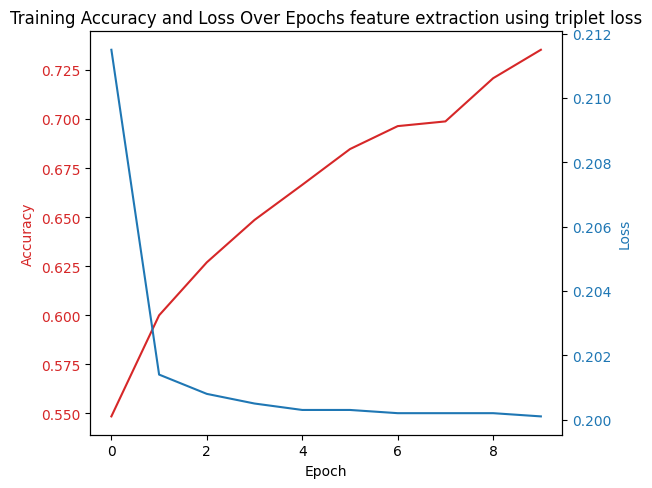

In [1]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(triplet_acc_list, label='Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(triplet_loss_list, label='Loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Accuracy and Loss Over Epochs feature extraction using triplet loss')
plt.show()

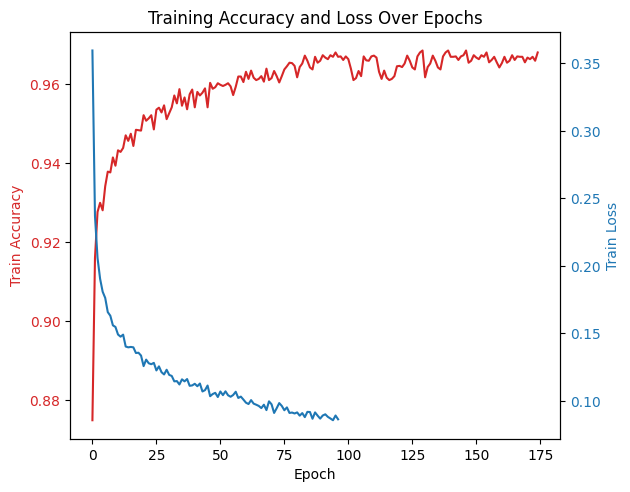

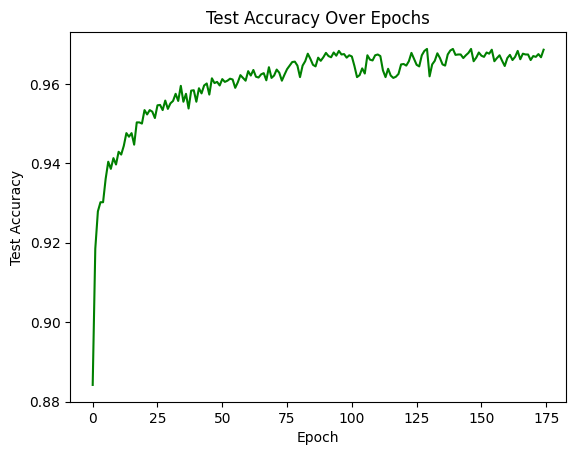

In [2]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Accuracy', color=color)
ax1.plot(train_acc, label='Train Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Train Loss', color=color)
ax2.plot(loss, label='Train Loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Accuracy and Loss Over Epochs')
plt.show()

# Plotting Test Accuracy
plt.figure()
plt.plot(test_acc, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()
